In [1]:
# common stuff
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import warnings
warnings.simplefilter('ignore')
%pylab inline
%config InlineBackend.figure_format = 'png' 
from pylab import rcParams
rcParams['figure.figsize'] = 8,5
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Load our data (taxi)

In [2]:
df = pd.read_csv('train.csv')
print(df.shape)
df.head(10)

(1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 133.5+ MB


no NaNs, good

In [4]:
# what's "id", is it just unique identifier of a ride
assert(df["id"].nunique() == len(df))
# yes it is

In [5]:
# what about others
[df[x].value_counts() for x in ["store_and_fwd_flag", "vendor_id", "passenger_count"]]
# only 2 vendors, up to 9 passengers

[N    1450599
 Y       8045
 Name: store_and_fwd_flag, dtype: int64, 2    780302
 1    678342
 Name: vendor_id, dtype: int64, 1    1033540
 2     210318
 5      78088
 3      59896
 6      48333
 4      28404
 0         60
 7          3
 9          1
 8          1
 Name: passenger_count, dtype: int64]

In [6]:
# we want to calculate distances, let's write vectorized haversine
def haversine_np(lon1, lat1, lon2, lat2):    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [7]:
# let's test if it actually works, this thing: http://www.movable-type.co.uk/scripts/latlong.html
# tells us that dist between (-73.982155, 40.767937) and (-73.964630, 40.765602) is 1.499km
haversine_np(-73.982155, 40.767937, -73.964630, 40.765602)
# well, looks pretty close

1.4976110138822747

In [8]:
# let's see if vectorized versions work
haversine_np(np.full((10, 1), -73.982155), np.full((10, 1), 40.767937),\
     np.full((10, 1), -73.964630), np.full((10, 1), 40.765602))

array([[ 1.49761101],
       [ 1.49761101],
       [ 1.49761101],
       [ 1.49761101],
       [ 1.49761101],
       [ 1.49761101],
       [ 1.49761101],
       [ 1.49761101],
       [ 1.49761101],
       [ 1.49761101]])

In [9]:
haversine_np(np.full((1, 10), -73.982155), np.full((1, 10), 40.767937),\
     np.full((1, 10), -73.964630), np.full((1, 10), 40.765602))

array([[ 1.49761101,  1.49761101,  1.49761101,  1.49761101,  1.49761101,
         1.49761101,  1.49761101,  1.49761101,  1.49761101,  1.49761101]])

In [10]:
# let's calculate all distances
df["dist_km"] = haversine_np(df["pickup_longitude"], df["pickup_latitude"], df["dropoff_longitude"], df["dropoff_latitude"]);
# and take minutes instead of seconds for duration
df["duration_m"] = df["trip_duration"] / 60.0
df.head(10)
# looks reasonable

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_km,duration_m
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.497580,7.583333
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.804374,11.050000
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.381090,35.400000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.484566,7.150000
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.187842,7.250000
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,1.098252,7.383333
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341,1.325446,5.683333
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551,5.711393,25.850000
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255,1.309531,4.250000
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225,5.117946,20.416667


In [11]:
df[["duration_m", "dist_km"]].describe()
# oops, there're some really long trips that f**ck up our stats, let's
# drop those for now

,duration_m,dist_km
count,1458644.000000,1458644.000000
mean,15.991538,3.438704
std,87.290529,4.293840
min,0.016667,0.000000
25%,6.616667,1.231063
50%,11.033333,2.092403
75%,17.916667,3.872904
max,58771.366667,1240.129578


In [12]:
df_s = df[(df.dist_km < df.dist_km.quantile(0.95)) & (df.trip_duration < df.trip_duration.quantile(0.95))]
df_s[["duration_m", "dist_km"]].describe()
# that's better

,duration_m,dist_km
count,1352592.000000,1352592.000000
mean,11.854582,2.605460
std,7.173243,2.070304
min,0.016667,0.000000
25%,6.316667,1.181895
50%,10.316667,1.947654
75%,16.000000,3.321319
max,35.050000,11.012182


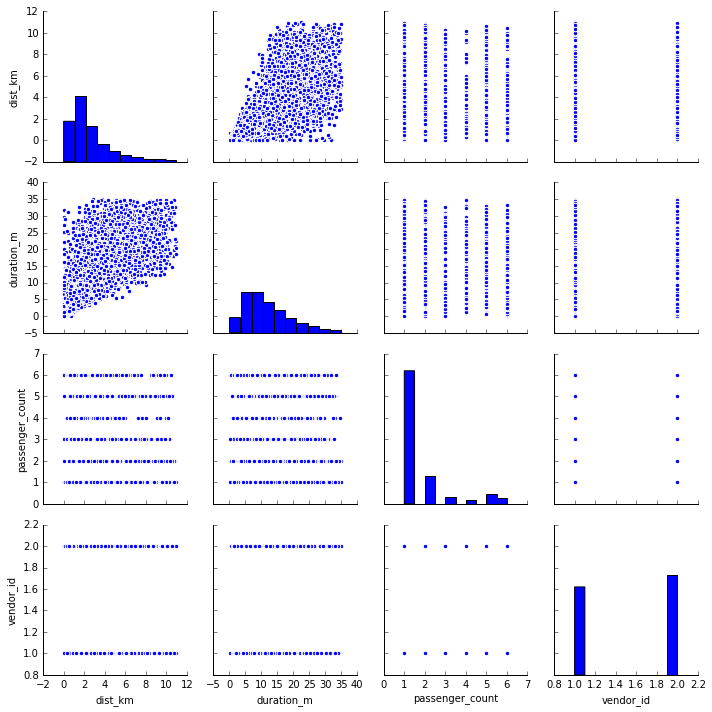

In [13]:
# let's see if there're interesting correlations
import seaborn as sns
df_s_tmp = df_s.head(10000)
sns.pairplot(df_s_tmp[['dist_km', 'duration_m', 'passenger_count', 'vendor_id']]);

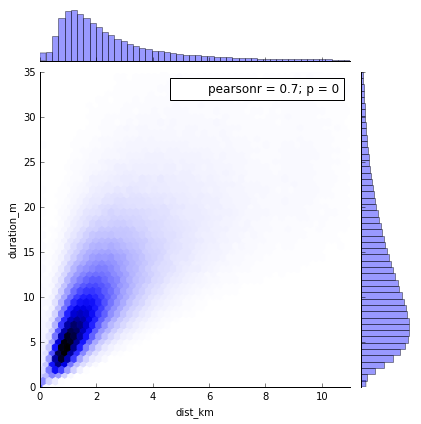

In [14]:
# let's take a closer look at distance/duration, we have a large dataset, using 'reg'
# or 'scatterplot' won't work nice (see above), let's use 'hex', it shows counts of observations
# that fall within hexagonal bins
sns.jointplot(x='dist_km', y='duration_m', data=df_s, kind='hex');

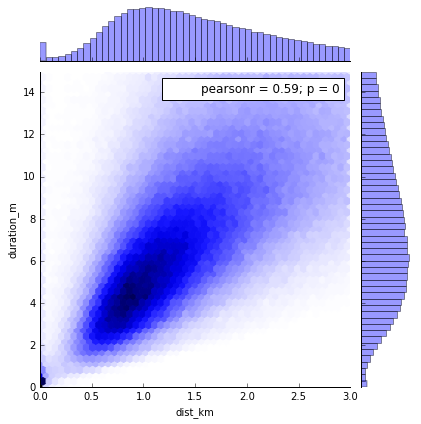

In [15]:
# there's clearly a corellation, let's "zoom in" where there're most samples
df_s_tmp2 = df_s[(df_s.dist_km < 3) & (df_s.duration_m < 15)]
sns.jointplot(x='dist_km', y='duration_m', data=df_s_tmp2, kind='hex');

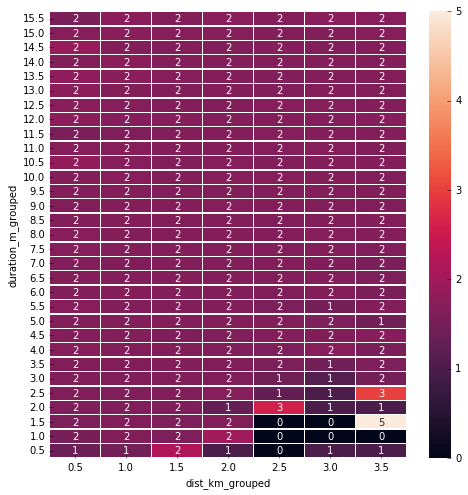

In [16]:
# we also want to see average number of people traveling
# for a given time/distance, let's build a heatmap
df_s["dist_km_grouped"] = pd.cut(df_s.dist_km, bins = arange(0, 4, 0.5), labels = arange(0.5, 4, 0.5))
df_s["duration_m_grouped"] = pd.cut(df_s.duration_m, bins = arange(0, 16, 0.5), labels = arange(0.5, 16, 0.5))
rcParams['figure.figsize'] = 8,8
dur_dist_passengers = df_s.pivot_table(
    index='duration_m_grouped', 
    columns='dist_km_grouped', 
    values='passenger_count', 
    aggfunc=mean).fillna(0).applymap(float)
sns.heatmap(dur_dist_passengers, annot=True, fmt=".0f", linewidths=.5).invert_yaxis()
rcParams['figure.figsize'] = 8,5

In [17]:
# Let's visualize all our routes using plotly
from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

df_map = df

longitude_range = [df_map[['pickup_longitude', 'dropoff_longitude']].min().min(), \
   df_map[['pickup_longitude', 'dropoff_longitude']].max().max()]
latitude_range = [df_map[['pickup_latitude', 'dropoff_latitude']].min().min(), \
   df_map[['pickup_latitude', 'dropoff_latitude']].max().max()]

longitude_bins = arange(longitude_range[0], longitude_range[1], 0.5)
latitude_bins = arange(latitude_range[0], latitude_range[1], 0.5)

df_map["plo_g"] = pd.cut(df_map.pickup_longitude, bins = longitude_bins, labels = longitude_bins[1:])
df_map["pla_g"] = pd.cut(df_map.pickup_latitude, bins = latitude_bins, labels = latitude_bins[1:])
df_map["dlo_g"] = pd.cut(df_map.dropoff_longitude, bins = longitude_bins, labels = longitude_bins[1:])
df_map["dla_g"] = pd.cut(df_map.dropoff_latitude, bins = latitude_bins, labels = latitude_bins[1:])

#a = df_map.groupby(['plo_g', 'pla_g', 'dlo_g', 'dla_g']).sum()

print(a.head(10))

#print(df[['pickup_longitude', 'dropoff_longitude']].max())
#print(df[['pickup_latitude', 'dropoff_latitude']].max())

#df_s["dist_km_grouped"] = pd.cut(df.dist_km, bins = [x for x in arange(0, 4, 0.5)], labels = [x for x in arange(0.5, 4, 0.5)])

paths = []
for i in range(1):
    paths.append(
        dict(
            type = 'scattergeo',
            locationmode = 'USA-states',
            lon = [ df_map['pickup_longitude'][i], df_map['dropoff_longitude'][i] ],
            lat = [ df_map['pickup_latitude'][i], df_map['dropoff_latitude'][i] ],
            mode = 'lines',
            line = dict(
                width = 1,
                color = 'red',
            ),            
        )
    )
    
layout = dict(
        title = 'AA',
        showlegend = False, 
        geo = dict(
            lataxis = dict(
                range = latitude_range,
                showgrid = True,                
                dtick = 10
            ),
            lonaxis = dict(
                range = longitude_range,
                showgrid = True,                
                dtick = 20
            ),
            projection=dict( type='azimuthal equal area' ),
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
fig = dict(data=paths, layout=layout)
iplot(fig)

NameError: name 'a' is not defined